In [1]:
import time
import datetime
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pybullet as p
import pybullet_data

import torch
from torch_cluster import radius_graph, radius
from torch_scatter import scatter

import matplotlib
import matplotlib.pyplot as plt

import edf
from edf.pybullet_env.utils import get_image, axiscreator, img_data_to_pointcloud
from edf.visual_utils import plot_color_and_depth, scatter_plot, scatter_plot_ax, visualize_samples, visualize_sample_cluster
from edf.pybullet_env.env import MugTask

device = 'cpu'
gpu_idx = 0
torch.cuda.set_device(gpu_idx)

pybullet build time: Dec  1 2021 18:34:28


In [2]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

stride = (7, 7)
stride_pick = (10, 10)
stride_place = (7, 7)

folder_name = 'demo'
task_name = 'mug_task_vis'
path = f'{folder_name}/{task_name}'
task = MugTask(use_gui=False)

upright_pose_seeds = [0,]

upright_samples = []
for seed in upright_pose_seeds:
    task.reset(seed = seed, cup_pose='upright')
    pc = task.observe_pointcloud(stride=(1,1))
    pre_grasp, grasp = task.oracle_pick_handle(random_180_flip=False)
    sample = {}
    sample['coord'] = pc['coord']
    sample['color'] = pc['color']
    sample['range'] = pc['ranges']
    sample['pre_grasp'] = pre_grasp 
    sample['grasp'] = grasp
    sample['images'] = task.observe()
    sample['center'] = task.center
    sample['stride'] = stride

    task.pick(pre_grasp, grasp, sleep=False)
    task.retract_robot(gripper_val=1.)
    pc = task.observe_pointcloud_pick(stride=(1,1))
    sample['coord_pick'] = pc['coord']
    sample['color_pick'] = pc['color']
    sample['range_pick'] = pc['ranges']
    sample['pick_pose'] = (pc['X_sg'], pc['R_sg'])
    sample['images_pick'] = task.observe_pick()
    sample['stride_pick'] = stride_pick
    
    pc = task.observe_pointcloud(stride=(1,1))
    pre_grasp, grasp = task.oracle_place_handle()
    sample['coord_place'] = pc['coord']
    sample['color_place'] = pc['color']
    sample['range_place'] = pc['ranges']
    sample['pre_place'] = pre_grasp 
    sample['place'] = grasp
    sample['images_place'] = task.observe()
    sample['stride_place'] = stride_place

    upright_samples.append(sample)

Identified 6433 IK solutions with minimum distance of 2.664 in 1.063 seconds


In [5]:
def visualize_samples_key(samples, coord_key='coord', color_key='color', range_key='range', grasp_key=None):
    sample_indices = np.arange(len(samples))
    sample_len = len(sample_indices)
    columns = 4
    rows = (sample_len-1) // columns + 1
    fig_W = 8

    fig, axes = plt.subplots(1, 1, figsize=(15,15), subplot_kw={'projection':'3d'})
    axes.axis('off')

    for i, sample_idx in enumerate(sample_indices):
        r,c = i//columns, i%columns
        sample = samples[sample_idx]
        coord, color = sample[coord_key], sample[color_key]
        ranges = sample[range_key]
        if grasp_key is not None:
            X_sg, R_sg = sample[grasp_key]
            frame_info = [{'frame':R_sg, 'origin':X_sg, 'alpha':0.5}]
        else:
            frame_info = []
        
        if rows == 1:
            scatter_plot_ax(axes, coord, color, ranges, frame_info)
        else:
            scatter_plot_ax(axes[r,c], coord, color, ranges, frame_info)

def visualize_samples(samples):
    visualize_samples_key(samples, coord_key='coord', color_key='color', range_key='range', grasp_key='grasp')
    visualize_samples_key(samples, coord_key='coord_pick', color_key='color_pick', range_key='range_pick', grasp_key=None)
    visualize_samples_key(samples, coord_key='coord_place', color_key='color_place', range_key='range_place', grasp_key='place')

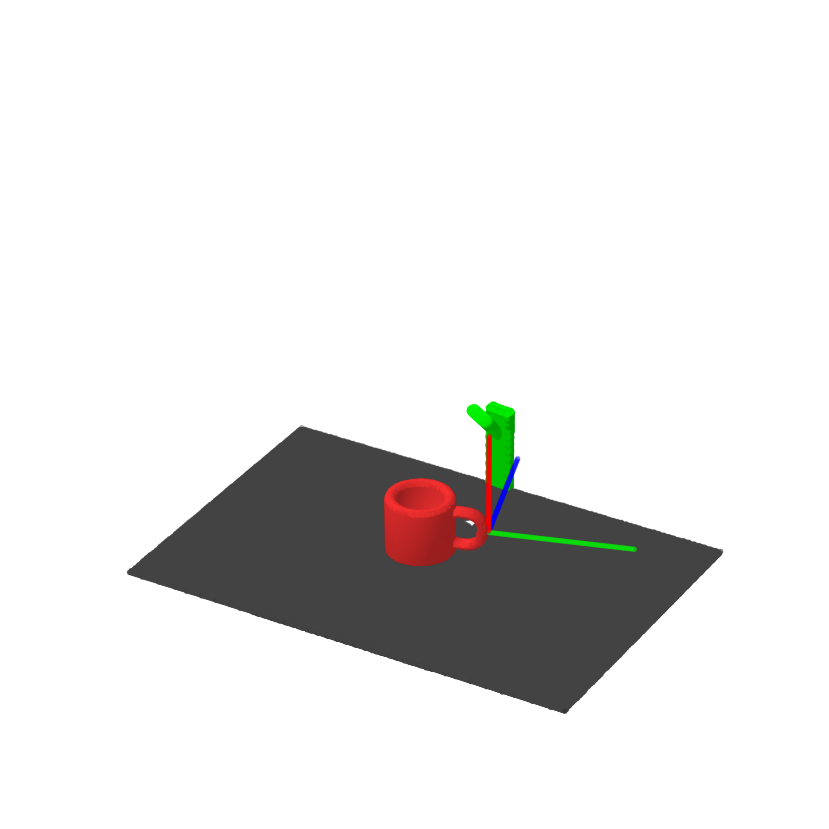

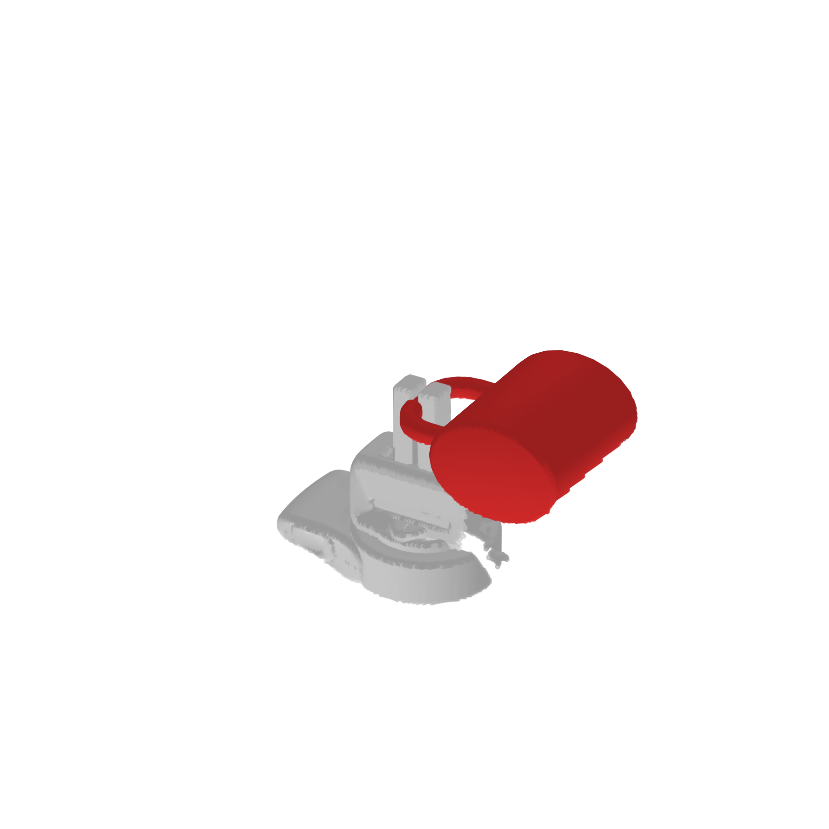

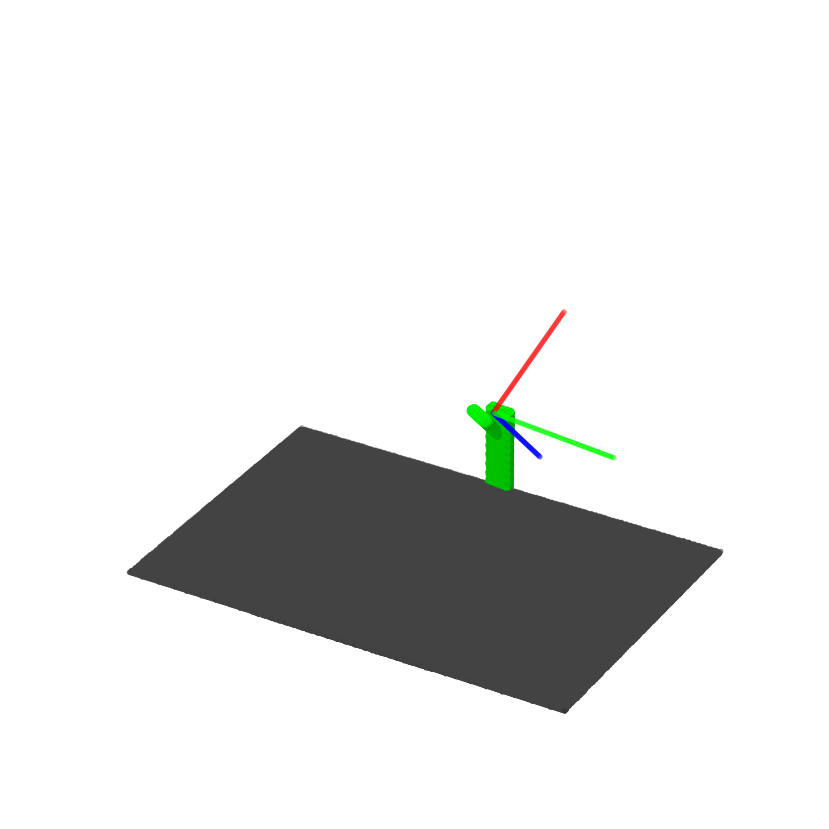

In [6]:
visualize_samples(upright_samples)